Import configs

In [1]:
# Core neuromaps modules
from neuromaps.datasets import fetch_annotation, fetch_atlas
from neuromaps.transforms import (
    fsaverage_to_fslr,
    fslr_to_fslr,
    civet_to_fslr,
)
from neuromaps.images import load_data, load_gifti
from neuromaps.stats import compare_images  # optional, for later correlations
from neuromaps.parcellate import Parcellater  # optional, for future analyses
from neuromaps import transforms  # optional, for direct access to transform functions

# Standard libraries
import os
from pathlib import Path

# Numeric and plotting
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

import os

# Add Connectome Workbench to PATH for neuromaps
os.environ["PATH"] = "/Applications/Workbench/bin_macosxub:" + os.environ["PATH"]

# Test that wb_command is now visible
import subprocess
subprocess.run(["wb_command", "-version"])


Connectome Workbench
Type: Command Line Application
Version: 2.0.1
Qt Compiled Version: 6.2.3
Qt Runtime Version: 6.2.3
Commit: 150de12f4f4b94b39bec6d9133ad2e7019d2d3ef
Commit Date: 2024-10-15 17:38:41 -0500
Compiler: c++ (/Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin)
Compiler Version: 13.0.0.13000029
Compiled Debug: NO
Operating System: Apple OSX
Compiled with OpenMP: YES


CompletedProcess(args=['wb_command', '-version'], returncode=0)

## Background

In the neuromaps paper, when comparing a source map (e.g., the schizophrenia map in MNI152) to multiple target maps, they always transformed the source map into the coordinate system of the target map.

However, for our source map (hcps1200 thickness fsLR 32k) and most target maps are already in surface spaces (fsLR, fsaverage, CIVET), and sometimes even the same one. So, we just apply that same rule logically but adapt it based on resolution.

Rules:
- If target and source share the same space and density → no transformation.
- If they share the same space but different densities → transform the higher-resolution dataset to the lower-resolution one.
- If they are in different spaces (fsaverage, CIVET, MNI152) → transform the target map to the source’s space (fsLR 32k).
This keeps everything aligned to a single reference grid for correlation

Assessing the impact of coordinate system
When transforming two datasets (that is, a source and target dataset) defined in distinct coordinate spaces to a common system there are at least three options available: transform the source dataset to the system of the target, transform the target dataset to the system of the source, or transform both source and target datasets to an alternate system. If comparisons are being made across several pairs of datasets a fourth option becomes available: always transform the higher resolution dataset to the system of the lower-resolution dataset.

## Source Map

In [2]:
source = fetch_annotation(source='hcps1200', desc='thickness', space='fsLR', den='32k')
ref_space = ("fsLR", "32k")


[References] Please cite the following papers if you are using this data:

  For {'source': 'hcps1200', 'desc': 'thickness', 'space': 'fsLR', 'den': '32k'}:
  [primary]:
    Matthew F Glasser, Timothy S Coalson, Emma C Robinson, Carl D Hacker, John Harwell, Essa Yacoub, Kamil Ugurbil, Jesper Andersson, Christian F Beckmann, Mark Jenkinson, and others. A multi-modal parcellation of human cerebral cortex. Nature, 536(7615):171–178, 2016.
  [secondary]:
    


## Target Maps

| #      | Category                                               | Source          | Description                | Space     | Density |
| ------ | ------------------------------------------------------ | --------------- | -------------------------- | --------- | ------- |
| **1**  | PC1 Gene Expression                                         | `abagen`        | `genepc1`                  | fsaverage | 10k     |
| **2**  | T1w/T2w Ratio                            | `hcps1200`      | `myelinmap`                | fsLR      | 32k     |
| **3**  | Developmental Expansion                                | `hill2010`      | `devexp`                   | fsLR      | 164k    |
| **4**  | Evolutionary Expansion              | `hill2010`      | `evoexp`   | fsLR      | 164k     |
| **5**  | Functional Gradient                             | `margulies2016` | `fcgradient01`  | fsLR      | 32k     |
| **6**  | Intersubject Variability                               | `mueller2013`   | `intersubjvar` | fsLR      | 164k     |
| **7**  | Cerebral Blood Flow                             | `raichle`       | `cbf`                      | fsLR      | 164k    |
| **8**  | Cerebral Blood Volume                           | `raichle`       | `cbv`                      | fsLR      | 164k    |
| **9** | Oxygen Metabolism                              | `raichle`       | `cmr02`                    | fsLR      | 164k    |
| **10** | Glucose Metabolism                            | `raichle`       | `cmrglc`                   | fsLR      | 164k    |
| **11** | Allometric Scaling (NIH) (Developmental Expansion Proxy) | `reardon2018`   | `scalingnih`               | CIVET     | 41k     |
| **12** | Allometric Scaling (PNC)                                | `reardon2018`   | `scalingpnc`               | CIVET     | 41k     |


## Transformations

In [3]:
from matplotlib import pyplot as plt
from matplotlib.cm import ScalarMappable
import matplotlib.colors as mcolors
import numpy as np
from nilearn.plotting import plot_surf
from neuromaps.datasets import ALIAS, fetch_atlas
from neuromaps.images import load_gifti
from neuromaps.transforms import _check_hemi

HEMI = dict(L='left', R='right')

def plot_surf_lateral_only(
    data, template, density, *,
    surf='inflated', hemi=None, mask_medial=True,
    colorbar='shared',          # 'none', 'each', or 'shared'
    cbar_location='right',      # 'right' or 'bottom' when colorbar='shared'
    vmin=None, vmax=None,       # shared limits. If None they are computed
    wspace=0.12, figsize=(10, 4), **kwargs
):
    """
    Lateral-only surface plot with optional shared colorbar.
    Returns (fig, cbar) where cbar can be None.
    """
    atlas = fetch_atlas(template, density, verbose=0)
    template = ALIAS.get(template, template)
    if template == 'MNI152':
        raise ValueError("Cannot plot MNI152 on the surface. Project to a surface first.")

    surf_geom = atlas[surf]
    medial = atlas['medial']

    # nilearn defaults
    opts = dict(alpha=1.0, threshold=np.spacing(1))
    opts.update(**kwargs)
    if kwargs.get('bg_map') is not None and kwargs.get('alpha') is None:
        opts['alpha'] = 'auto'

    data, hemispheres = zip(*_check_hemi(data, hemi))
    n_hemi = len(data)

    # collect data arrays to compute shared limits if needed
    arrays = []
    for img in data:
        arr = load_gifti(img).agg_data().astype('float32')
        if mask_medial:
            # we do not know hemisphere here yet, compute after
            arrays.append(arr)
        else:
            arrays.append(arr)

    if vmin is None or vmax is None:
        # robust range across hemispheres
        allvals = np.concatenate([np.ravel(a[np.isfinite(a)]) for a in arrays])
        vmin = np.nanmin(allvals) if vmin is None else vmin
        vmax = np.nanmax(allvals) if vmax is None else vmax
    opts.update(dict(vmin=vmin, vmax=vmax))

    fig, axes = plt.subplots(1, n_hemi, subplot_kw={'projection': '3d'}, figsize=figsize)
    axes = (axes,) if n_hemi == 1 else axes

    # if we will add a shared colorbar, turn per-panel colorbars off
    per_panel_cbar = (colorbar == 'each')
    if colorbar == 'shared':
        opts['colorbar'] = False
    else:
        opts['colorbar'] = per_panel_cbar

    for ax, h, img in zip(axes, hemispheres, data):
        geom = load_gifti(getattr(surf_geom, h)).agg_data()
        arr = load_gifti(img).agg_data().astype('float32')
        if mask_medial:
            med = load_gifti(getattr(medial, h)).agg_data().astype(bool)
            arr[~med] = np.nan

        ax.disable_mouse_rotation()
        plot_surf(geom, arr, hemi=HEMI[h], axes=ax, view='lateral', **opts)

    # spacing between hemispheres
    fig.subplots_adjust(wspace=wspace)

    # optional shared colorbar
    cbar = None
    if colorbar == 'shared':
        sm = ScalarMappable(norm=mcolors.Normalize(vmin=vmin, vmax=vmax),
                            cmap=opts.get('cmap', None))
        sm.set_array([])
        if cbar_location == 'right':
            cbar = fig.colorbar(sm, ax=axes, location='right', fraction=0.05, pad=0.03)
        else:  # bottom
            cbar = fig.colorbar(sm, ax=axes, location='bottom', fraction=0.05, pad=0.3)

    return fig, cbar


### PC1 gene expression

In [4]:
genepc1 = fetch_annotation(source='abagen', desc='genepc1', space='fsaverage', den='10k')
genepc1_fsLR32k = fsaverage_to_fslr(genepc1, target_density='32k')


[References] Please cite the following papers if you are using this data:

  For {'source': 'abagen', 'desc': 'genepc1', 'space': 'fsaverage', 'den': '10k'}:
  [primary]:
    Michael J Hawrylycz, Ed S Lein, Angela L Guillozet-Bongaarts, Elaine H Shen, Lydia Ng, Jeremy A Miller, Louie N Van De Lagemaat, Kimberly A Smith, Amanda Ebbert, Zackery L Riley, and others. An anatomically comprehensive atlas of the adult human brain transcriptome. Nature, 489(7416):391, 2012.
    Ross D Markello, Aurina Arnatkeviciute, Jean-Baptiste Poline, Ben D Fulcher, Alex Fornito, and Bratislav Misic. Standardizing workflows in imaging transcriptomics with the abagen toolbox. eLife, 10:e72129, 2021.
  [secondary]:
    


/var/folders/bn/y9bv_0r52t72ds1rf8hb3rzh0000gn/T/ipykernel_21337/546474004.py:76: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plot_surf(geom, arr, hemi=HEMI[h], axes=ax, view='lateral', **opts)


Text(0.5, 0.98, 'PC1 fsLR 32k')

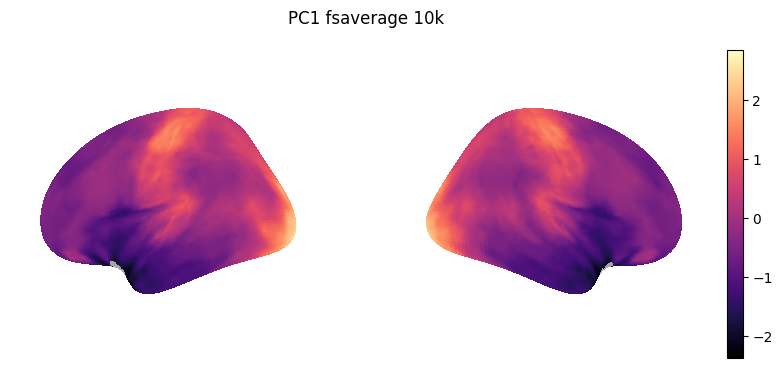

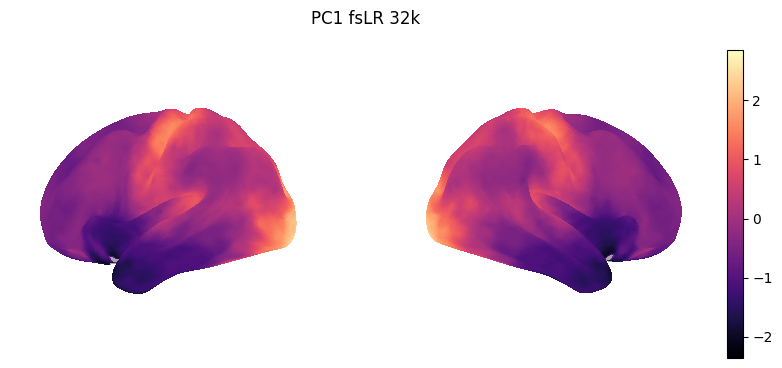

In [5]:
fig1, cbar1 = plot_surf_lateral_only(
    genepc1, template='fsaverage', density='10k',
    cmap='magma', colorbar='shared', cbar_location='right', wspace=0.18
)
fig1.suptitle('PC1 fsaverage 10k', y=0.98)

fig2, cbar2 = plot_surf_lateral_only(
    genepc1_fsLR32k, template='fsLR', density='32k',
    cmap='magma', colorbar='shared', cbar_location='right', wspace=0.18
)
fig2.suptitle('PC1 fsLR 32k', y=0.98)


### T1w/T2w ratio

In [6]:
myelinmap = fetch_annotation(source='hcps1200', desc='myelinmap', space='fsLR', den='32k')
myelinmap_fsLR32k = myelinmap  # already in target space


[References] Please cite the following papers if you are using this data:

  For {'source': 'hcps1200', 'desc': 'myelinmap', 'space': 'fsLR', 'den': '32k'}:
  [primary]:
    Matthew F Glasser, Timothy S Coalson, Emma C Robinson, Carl D Hacker, John Harwell, Essa Yacoub, Kamil Ugurbil, Jesper Andersson, Christian F Beckmann, Mark Jenkinson, and others. A multi-modal parcellation of human cerebral cortex. Nature, 536(7615):171–178, 2016.
  [secondary]:
    


/var/folders/bn/y9bv_0r52t72ds1rf8hb3rzh0000gn/T/ipykernel_21337/546474004.py:76: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plot_surf(geom, arr, hemi=HEMI[h], axes=ax, view='lateral', **opts)


Text(0.5, 0.98, 'T1w/T2w ratio fsLR 32k')

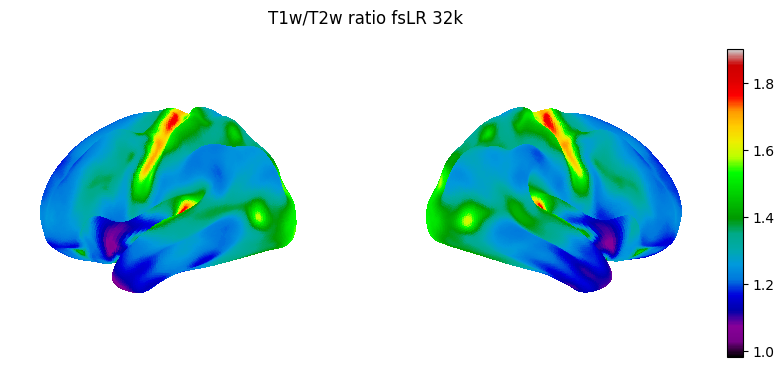

In [7]:
fig3, cbar3 = plot_surf_lateral_only(
    myelinmap_fsLR32k, template='fsLR', density='32k',
    cmap='nipy_spectral', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=0.98, vmax=1.9
)
fig3.suptitle('T1w/T2w ratio fsLR 32k', y=0.98)

### Developmental expansion



In [8]:
devexp = fetch_annotation(source='hill2010', desc='devexp', space='fsLR', den='164k')
print(type(devexp), devexp)


[References] Please cite the following papers if you are using this data:

  For {'source': 'hill2010', 'desc': 'devexp', 'space': 'fsLR', 'den': '164k'}:
  [primary]:
    Jason Hill, Terrie Inder, Jeffrey Neil, Donna Dierker, John Harwell, and David Van Essen. Similar patterns of cortical expansion during human development and evolution. Proceedings of the National Academy of Sciences, 107(29):13135–13140, 2010.
  [secondary]:
    
<class 'str'> /Users/paigepagaduan/neuromaps-data/annotations/hill2010/devexp/fsLR/source-hill2010_desc-devexp_space-fsLR_den-164k_hemi-R_feature.func.gii


Because hill2010/devexp only exists for the right hemisphere we transformed it like this:

In [9]:
devexp = fetch_annotation(source='hill2010', desc='devexp', space='fsLR', den='164k')
devexp_fsLR = fslr_to_fslr(devexp, '32k', hemi='R')


[References] Please cite the following papers if you are using this data:

  For {'source': 'hill2010', 'desc': 'devexp', 'space': 'fsLR', 'den': '164k'}:
  [primary]:
    Jason Hill, Terrie Inder, Jeffrey Neil, Donna Dierker, John Harwell, and David Van Essen. Similar patterns of cortical expansion during human development and evolution. Proceedings of the National Academy of Sciences, 107(29):13135–13140, 2010.
  [secondary]:
    


/var/folders/bn/y9bv_0r52t72ds1rf8hb3rzh0000gn/T/ipykernel_21337/546474004.py:76: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plot_surf(geom, arr, hemi=HEMI[h], axes=ax, view='lateral', **opts)


Text(0.5, 0.98, 'Developmental expansion fsLR 32k')

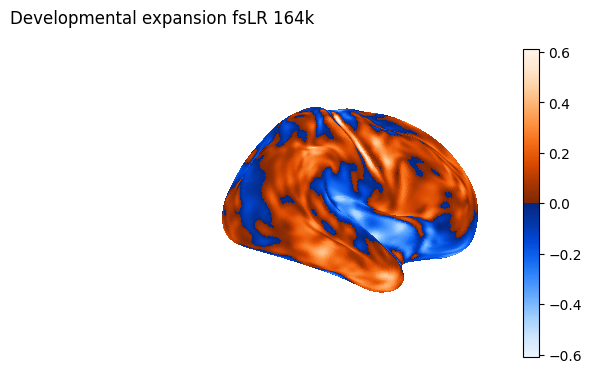

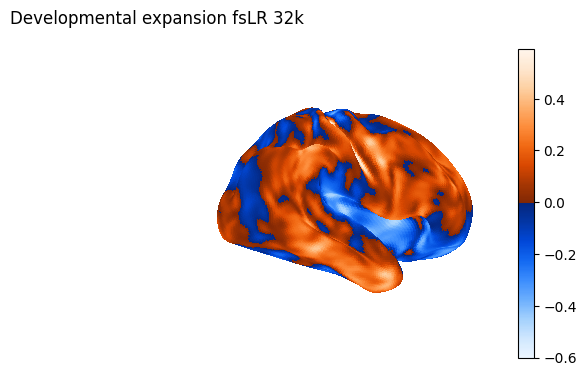

In [10]:
fig4, cbar4 = plot_surf_lateral_only(
    devexp, template='fsLR', density='164k', hemi='R',
    cmap='blue_orange', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=-0.61, vmax=0.61
)
fig4.suptitle('Developmental expansion fsLR 164k', y=0.98)

fig5, cbar5 = plot_surf_lateral_only(
    devexp_fsLR, template='fsLR', density='32k', hemi='R',
    cmap='blue_orange', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=-0.6, vmax=0.59
)
fig5.suptitle('Developmental expansion fsLR 32k', y=0.98)

### Evolutionary expansion



In [11]:
evoexp = fetch_annotation(source='hill2010', desc='evoexp', space='fsLR', den='164k')
evoexp_fsLR32k = fslr_to_fslr(evoexp, '32k', hemi='R')


[References] Please cite the following papers if you are using this data:

  For {'source': 'hill2010', 'desc': 'evoexp', 'space': 'fsLR', 'den': '164k'}:
  [primary]:
    Jason Hill, Terrie Inder, Jeffrey Neil, Donna Dierker, John Harwell, and David Van Essen. Similar patterns of cortical expansion during human development and evolution. Proceedings of the National Academy of Sciences, 107(29):13135–13140, 2010.
  [secondary]:
    


/var/folders/bn/y9bv_0r52t72ds1rf8hb3rzh0000gn/T/ipykernel_21337/546474004.py:76: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plot_surf(geom, arr, hemi=HEMI[h], axes=ax, view='lateral', **opts)


Text(0.5, 0.98, 'Evolutionary expansion fsLR 32k')

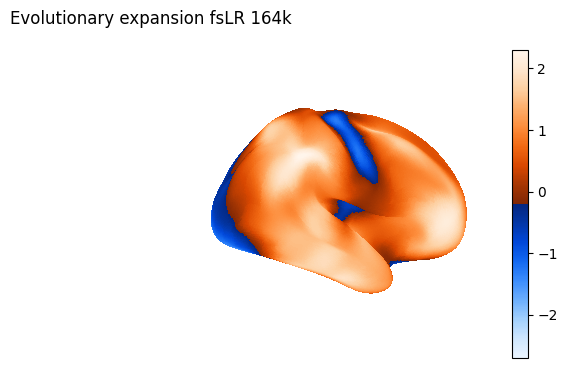

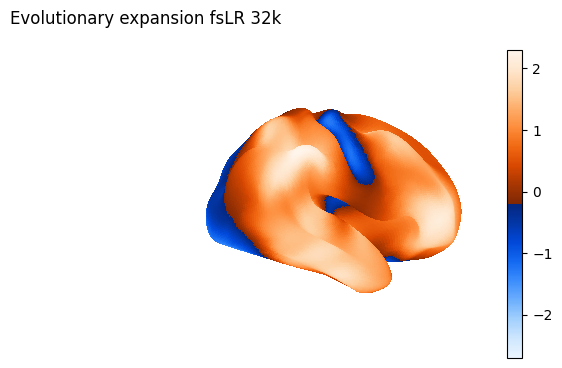

In [12]:
fig6, cbar6 = plot_surf_lateral_only(
    evoexp, template='fsLR', density='164k', hemi='R',
    cmap='blue_orange', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=-2.7, vmax=2.3
)
fig6.suptitle('Evolutionary expansion fsLR 164k', y=0.98)

fig7, cbar7 = plot_surf_lateral_only(
    evoexp_fsLR32k, template='fsLR', density='32k', hemi='R',
    cmap='blue_orange', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=-2.7, vmax=2.3
)
fig7.suptitle('Evolutionary expansion fsLR 32k', y=0.98)

### Functional gradient



In [13]:
gradient_pc1 = fetch_annotation(source='margulies2016', desc='fcgradient01', space='fsLR', den='32k')
gradient_pc1_fsLR32k = gradient_pc1


[References] Please cite the following papers if you are using this data:

  For {'source': 'margulies2016', 'desc': 'fcgradient01', 'space': 'fsLR', 'den': '32k'}:
  [primary]:
    Daniel S Margulies, Satrajit S Ghosh, Alexandros Goulas, Marcel Falkiewicz, Julia M Huntenburg, Georg Langs, Gleb Bezgin, Simon B Eickhoff, F Xavier Castellanos, Michael Petrides, and others. Situating the default-mode network along a principal gradient of macroscale cortical organization. Proc Natl Acad Sci USA, 113(44):12574–12579, 2016.
  [secondary]:
    


/var/folders/bn/y9bv_0r52t72ds1rf8hb3rzh0000gn/T/ipykernel_21337/546474004.py:76: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plot_surf(geom, arr, hemi=HEMI[h], axes=ax, view='lateral', **opts)


Text(0.5, 0.98, 'Functional gradient fsLR 32k')

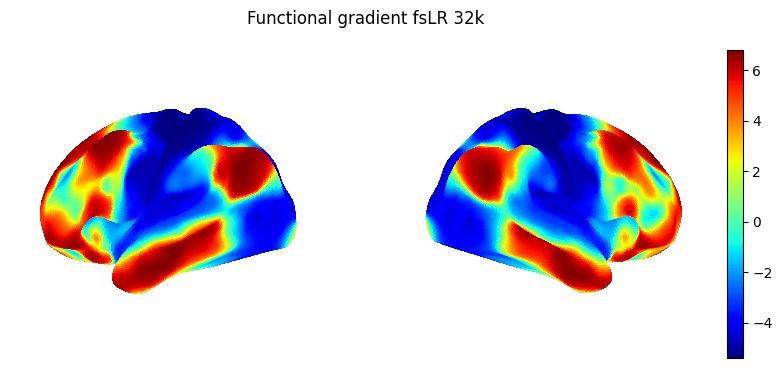

In [14]:
fig8, cbar8 = plot_surf_lateral_only(
    gradient_pc1_fsLR32k, template='fsLR', density='32k',
    cmap='jet', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=-5.4, vmax=6.8
)
fig8.suptitle('Functional gradient fsLR 32k', y=0.98)

### Intersubject variability



In [15]:
isv = fetch_annotation(source='mueller2013', desc='intersubjvar', space='fsLR', den='164k')
isv_fsLR32k = fslr_to_fslr(isv, target_density='32k')


[References] Please cite the following papers if you are using this data:

  For {'source': 'mueller2013', 'desc': 'intersubjvar', 'space': 'fsLR', 'den': '164k'}:
  [primary]:
    Sophia Mueller, Danhong Wang, Michael D Fox, BT Thomas Yeo, Jorge Sepulcre, Mert R Sabuncu, Rebecca Shafee, Jie Lu, and Hesheng Liu. Individual variability in functional connectivity architecture of the human brain. Neuron, 77(3):586–595, 2013.
  [secondary]:
    


/var/folders/bn/y9bv_0r52t72ds1rf8hb3rzh0000gn/T/ipykernel_21337/546474004.py:76: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plot_surf(geom, arr, hemi=HEMI[h], axes=ax, view='lateral', **opts)


Text(0.5, 0.98, 'Intersubject variability fsLR 32k')

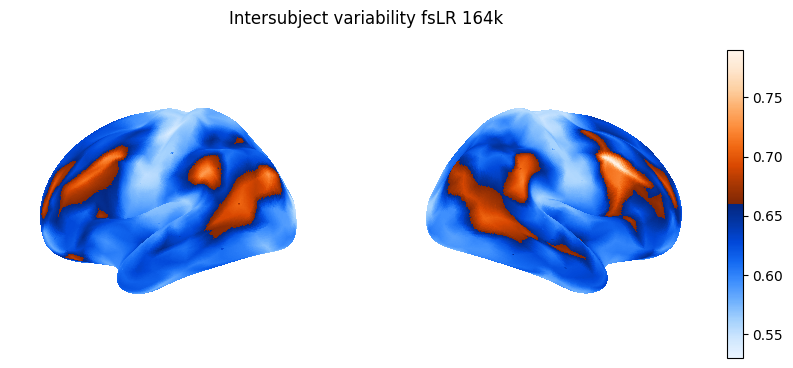

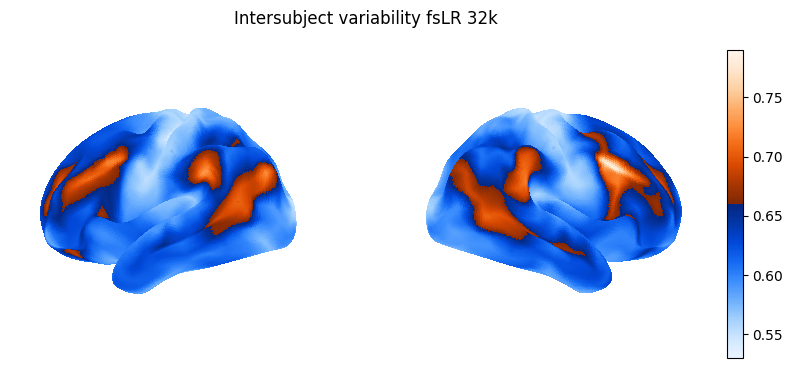

In [16]:
fig9, cbar9 = plot_surf_lateral_only(
    isv, template='fsLR', density='164k',
    cmap='blue_orange', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=0.53, vmax=0.79
)
fig9.suptitle('Intersubject variability fsLR 164k', y=0.98)

fig10, cbar11 = plot_surf_lateral_only(
    isv_fsLR32k, template='fsLR', density='32k',
    cmap='blue_orange', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=0.53, vmax=0.79
)
fig10.suptitle('Intersubject variability fsLR 32k', y=0.98)

### Cerebral blood flow



In [17]:
cbf = fetch_annotation(source='raichle', desc='cbf', space='fsLR', den='164k')
cbf_fsLR32k = fslr_to_fslr(cbf, target_density='32k')


[References] Please cite the following papers if you are using this data:

  For {'source': 'raichle', 'desc': 'cbf', 'space': 'fsLR', 'den': '164k'}:
  [primary]:
    S Neil Vaishnavi, Andrei G Vlassenko, Melissa M Rundle, Abraham Z Snyder, Mark A Mintun, and Marcus E Raichle. Regional aerobic glycolysis in the human brain. Proceedings of the National Academy of Sciences, 107(41):17757–17762, 2010.
  [secondary]:
    


/var/folders/bn/y9bv_0r52t72ds1rf8hb3rzh0000gn/T/ipykernel_21337/546474004.py:76: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plot_surf(geom, arr, hemi=HEMI[h], axes=ax, view='lateral', **opts)


Text(0.5, 0.98, 'Cerebral blood flow fsLR 32k')

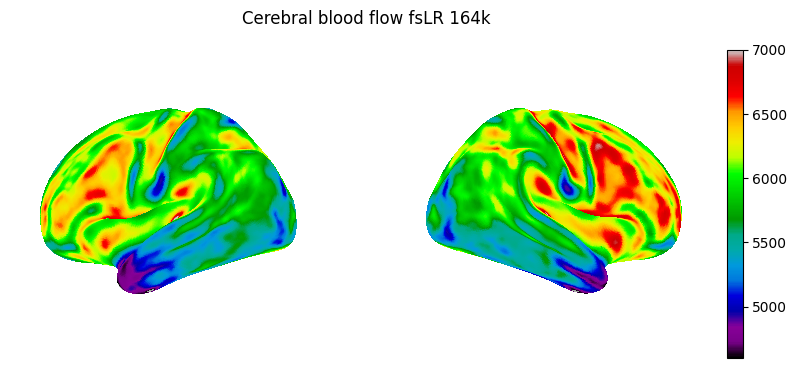

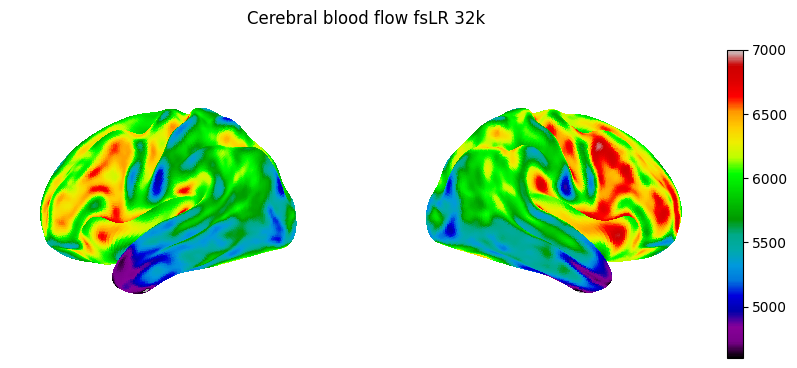

In [18]:
fig11, cbar11 = plot_surf_lateral_only(
    cbf, template='fsLR', density='164k',
    cmap='nipy_spectral', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=4600, vmax=7000
)
fig11.suptitle('Cerebral blood flow fsLR 164k', y=0.98)

fig12, cbar12 = plot_surf_lateral_only(
    cbf_fsLR32k, template='fsLR', density='32k',
    cmap='nipy_spectral', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=4600, vmax=7000
)
fig12.suptitle('Cerebral blood flow fsLR 32k', y=0.98)

### Cerebral blood volume



In [19]:
cbv = fetch_annotation(source='raichle', desc='cbv', space='fsLR', den='164k')
cbv_fsLR32k = fslr_to_fslr(cbv, target_density='32k')


[References] Please cite the following papers if you are using this data:

  For {'source': 'raichle', 'desc': 'cbv', 'space': 'fsLR', 'den': '164k'}:
  [primary]:
    S Neil Vaishnavi, Andrei G Vlassenko, Melissa M Rundle, Abraham Z Snyder, Mark A Mintun, and Marcus E Raichle. Regional aerobic glycolysis in the human brain. Proceedings of the National Academy of Sciences, 107(41):17757–17762, 2010.
  [secondary]:
    


/var/folders/bn/y9bv_0r52t72ds1rf8hb3rzh0000gn/T/ipykernel_21337/546474004.py:76: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plot_surf(geom, arr, hemi=HEMI[h], axes=ax, view='lateral', **opts)


Text(0.5, 0.98, 'Cerebral blood volume fsLR 32k')

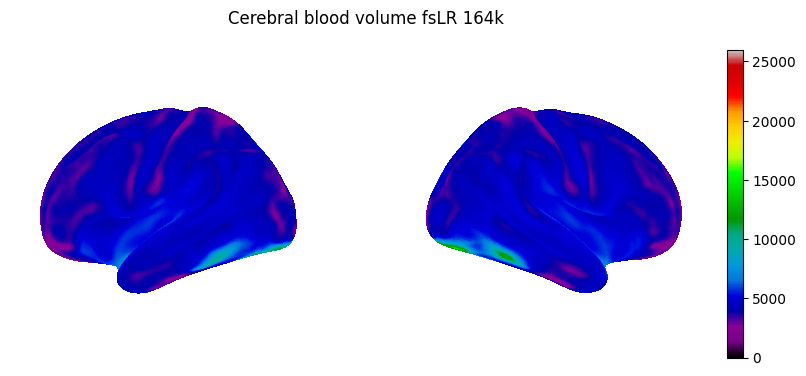

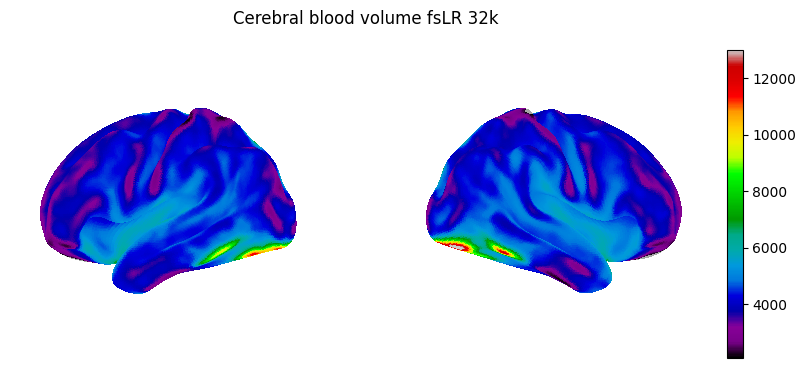

In [20]:
fig13, cbar13 = plot_surf_lateral_only(
    cbv, template='fsLR', density='164k',
    cmap='nipy_spectral', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=0, vmax=26000
)
fig13.suptitle('Cerebral blood volume fsLR 164k', y=0.98)

fig14, cbar14 = plot_surf_lateral_only(
    cbv_fsLR32k, template='fsLR', density='32k',
    cmap='nipy_spectral', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=2100, vmax=13000
)
fig14.suptitle('Cerebral blood volume fsLR 32k', y=0.98)

### Oxygen metabolism



In [21]:
cmro2 = fetch_annotation(source='raichle', desc='cmr02', space='fsLR', den='164k')
cmro2_fsLR32k = fslr_to_fslr(cmro2, target_density='32k')


[References] Please cite the following papers if you are using this data:

  For {'source': 'raichle', 'desc': 'cmr02', 'space': 'fsLR', 'den': '164k'}:
  [primary]:
    S Neil Vaishnavi, Andrei G Vlassenko, Melissa M Rundle, Abraham Z Snyder, Mark A Mintun, and Marcus E Raichle. Regional aerobic glycolysis in the human brain. Proceedings of the National Academy of Sciences, 107(41):17757–17762, 2010.
  [secondary]:
    


/var/folders/bn/y9bv_0r52t72ds1rf8hb3rzh0000gn/T/ipykernel_21337/546474004.py:76: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plot_surf(geom, arr, hemi=HEMI[h], axes=ax, view='lateral', **opts)


Text(0.5, 0.98, 'Oxygen metabolism fsLR 32k')

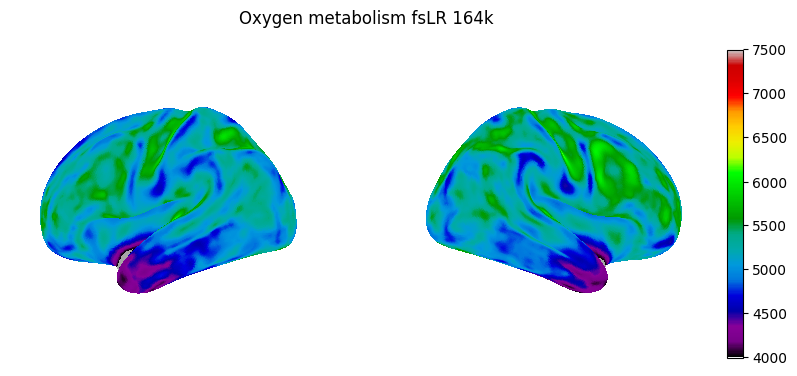

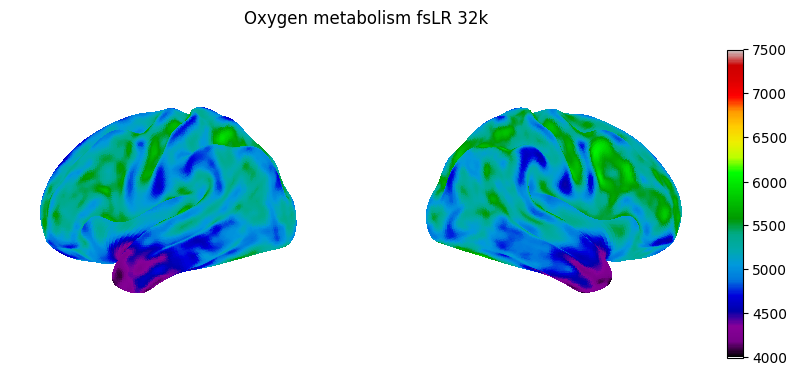

In [22]:
fig15, cbar15 = plot_surf_lateral_only(
    cmro2, template='fsLR', density='164k',
    cmap='nipy_spectral', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=4000, vmax=7500
)
fig15.suptitle('Oxygen metabolism fsLR 164k', y=0.98)

fig16, cbar16 = plot_surf_lateral_only(
    cmro2_fsLR32k, template='fsLR', density='32k',
    cmap='nipy_spectral', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=4000, vmax=7500
)
fig16.suptitle('Oxygen metabolism fsLR 32k', y=0.98)

### Glucose metabolism



In [23]:
cmrglc = fetch_annotation(source='raichle', desc='cmrglc', space='fsLR', den='164k')
cmrglc_fsLR32k = fslr_to_fslr(cmrglc, target_density='32k')


[References] Please cite the following papers if you are using this data:

  For {'source': 'raichle', 'desc': 'cmrglc', 'space': 'fsLR', 'den': '164k'}:
  [primary]:
    S Neil Vaishnavi, Andrei G Vlassenko, Melissa M Rundle, Abraham Z Snyder, Mark A Mintun, and Marcus E Raichle. Regional aerobic glycolysis in the human brain. Proceedings of the National Academy of Sciences, 107(41):17757–17762, 2010.
  [secondary]:
    


/var/folders/bn/y9bv_0r52t72ds1rf8hb3rzh0000gn/T/ipykernel_21337/546474004.py:76: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plot_surf(geom, arr, hemi=HEMI[h], axes=ax, view='lateral', **opts)


Text(0.5, 0.98, 'Glucose metabolism fsLR 32k')

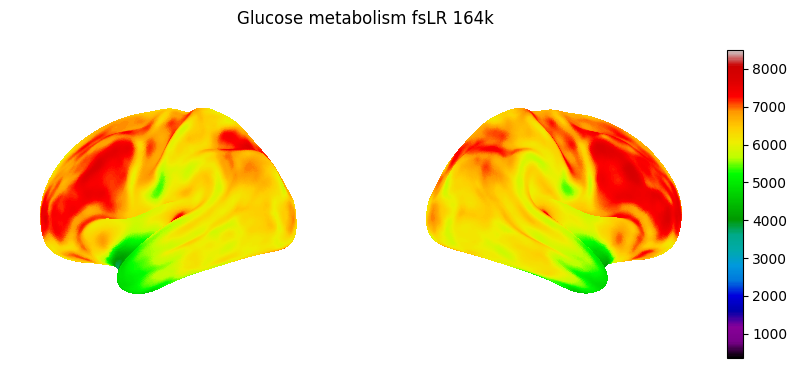

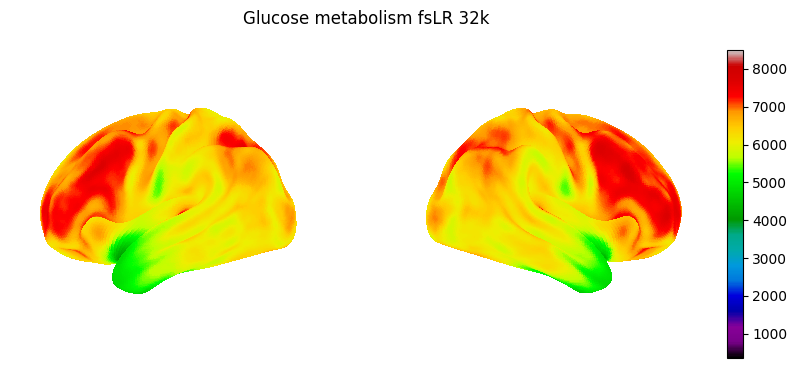

In [24]:
fig17, cbar17 = plot_surf_lateral_only(
    cmrglc, template='fsLR', density='164k',
    cmap='nipy_spectral', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=360, vmax=8500
)
fig17.suptitle('Glucose metabolism fsLR 164k', y=0.98)

fig18, cbar18 = plot_surf_lateral_only(
    cmrglc_fsLR32k, template='fsLR', density='32k',
    cmap='nipy_spectral', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=360, vmax=8500
)
fig18.suptitle('Glucose metabolism fsLR 32k', y=0.98)

### Allometric scaling (NIH)



In [25]:
scalingnih = fetch_annotation(source='reardon2018', desc='scalingnih', space='civet', den='41k')
scalingnih_fsLR32k = civet_to_fslr(scalingnih, target_density='32k')


[References] Please cite the following papers if you are using this data:

  For {'source': 'reardon2018', 'desc': 'scalingnih', 'space': 'civet', 'den': '41k'}:
  [primary]:
    PK Reardon, Jakob Seidlitz, Simon Vandekar, Siyuan Liu, Raihaan Patel, Min Tae M Park, Aaron Alexander-Bloch, Liv S Clasen, Jonathan D Blumenthal, Francois M Lalonde, and others. Normative brain size variation and brain shape diversity in humans. Science, 360(6394):1222–1227, 2018.
  [secondary]:
    


/var/folders/bn/y9bv_0r52t72ds1rf8hb3rzh0000gn/T/ipykernel_21337/546474004.py:76: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plot_surf(geom, arr, hemi=HEMI[h], axes=ax, view='lateral', **opts)


Text(0.5, 0.98, 'Allometric scaling (NIH) fsLR 32k')

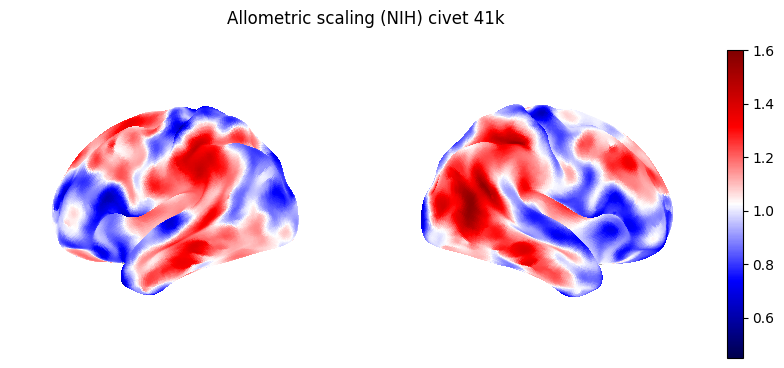

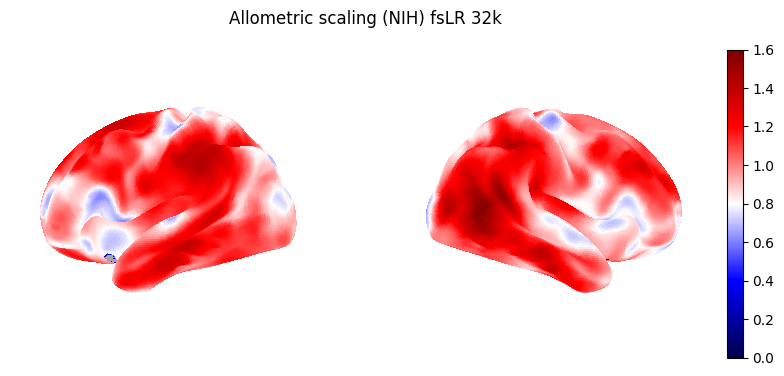

In [26]:
fig19, cbar19 = plot_surf_lateral_only(
    scalingnih, template='civet', density='41k',
    cmap='seismic', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=0.45, vmax=1.6
)
fig19.suptitle('Allometric scaling (NIH) civet 41k', y=0.98)

fig20, cbar20 = plot_surf_lateral_only(
    scalingnih_fsLR32k, template='fsLR', density='32k',
    cmap='seismic', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=0, vmax=1.6
)
fig20.suptitle('Allometric scaling (NIH) fsLR 32k', y=0.98)

### Allometric scaling (PNC)



In [27]:
scalingpnc = fetch_annotation(source='reardon2018', desc='scalingpnc', space='civet', den='41k')
scalingpnc_fsLR32k = civet_to_fslr(scalingpnc, target_density='32k')


[References] Please cite the following papers if you are using this data:

  For {'source': 'reardon2018', 'desc': 'scalingpnc', 'space': 'civet', 'den': '41k'}:
  [primary]:
    PK Reardon, Jakob Seidlitz, Simon Vandekar, Siyuan Liu, Raihaan Patel, Min Tae M Park, Aaron Alexander-Bloch, Liv S Clasen, Jonathan D Blumenthal, Francois M Lalonde, and others. Normative brain size variation and brain shape diversity in humans. Science, 360(6394):1222–1227, 2018.
  [secondary]:
    


/var/folders/bn/y9bv_0r52t72ds1rf8hb3rzh0000gn/T/ipykernel_21337/546474004.py:76: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plot_surf(geom, arr, hemi=HEMI[h], axes=ax, view='lateral', **opts)


Text(0.5, 0.98, 'Allometric scaling (PNC) fsLR 32k')

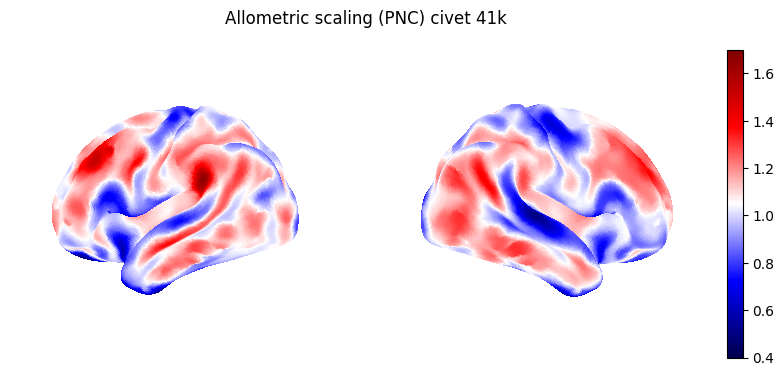

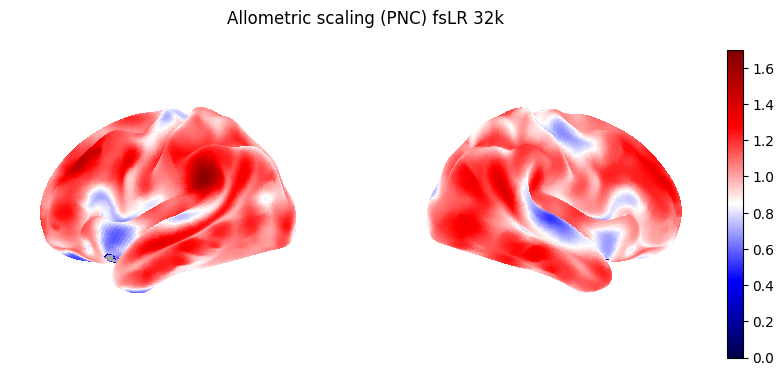

In [28]:
fig21, cbar21 = plot_surf_lateral_only(
    scalingpnc, template='civet', density='41k',
    cmap='seismic', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=0.4, vmax=1.7
)
fig21.suptitle('Allometric scaling (PNC) civet 41k', y=0.98)

fig22, cbar22 = plot_surf_lateral_only(
    scalingpnc_fsLR32k, template='fsLR', density='32k',
    cmap='seismic', colorbar='shared', cbar_location='right', wspace=0.18,
    vmin=0, vmax=1.7
)
fig22.suptitle('Allometric scaling (PNC) fsLR 32k', y=0.98)

FileNotFoundError: [Errno 2] No such file or directory: 'fig23.png'

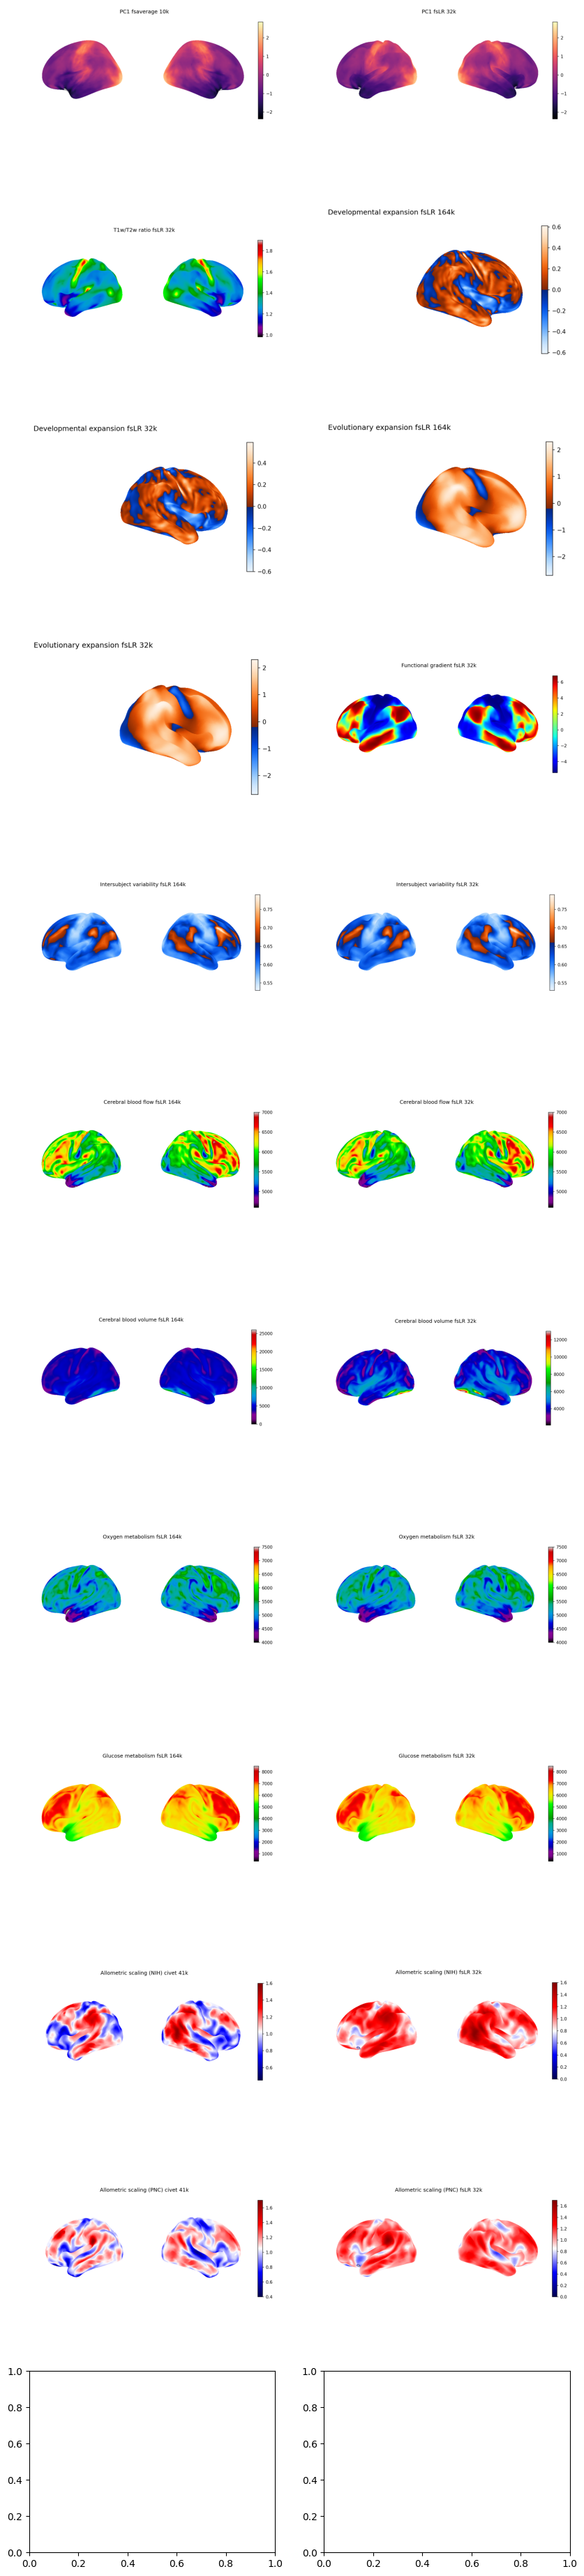

In [32]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Save your individual figures
for i, fig in enumerate([fig1, fig2, fig3, fig5, fig6, fig7, fig8, fig9, fig10,
        fig11, fig12, fig13, fig14, fig15, fig16, fig17, fig18, fig19,
        fig20, fig21, fig22, fig23], start=1):
    fig.savefig(f'fig{i}.png', dpi=150, bbox_inches='tight')

# Combine into two columns
fig, axes = plt.subplots(12, 2, figsize=(10, 48))  # 23 → 12 rows x 2 cols
axes = axes.flatten()

for i in range(23):
    img = mpimg.imread(f'fig{i+1}.png')
    axes[i].imshow(img)
    axes[i].axis('off')

# Hide any empty subplot
for j in range(23, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()
